<a href="https://colab.research.google.com/github/microsoft/qlib/blob/main/examples/workflow_by_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow of Qlib

## Importing Dependencies

In [1]:
from datetime import datetime
import os
from pathlib import Path
import pickle
import sys
import qlib
from qlib.config import REG_CN
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, SigAnaRecord, PortAnaRecord
from qlib.contrib.model.pytorch_master_ts import MASTERModel
from qlib.contrib.data.dataset import MASTERTSDatasetH
from qlib.contrib.data.handler import Alpha158

## Initializing Qlib

In [2]:
from qlib.tests.data import GetData


provider_uri = "~/QuantProject/.qlib/qlib_data/cn_data"
GetData().qlib_data(target_dir=provider_uri, region=REG_CN, exists_skip=True)
qlib.init(provider_uri=provider_uri, region=REG_CN)

2025-04-07 03:39:14.627 | WARNING  | qlib.tests.data:qlib_data:195 - Data already exists: ~/QuantProject/.qlib/qlib_data/cn_data, the data download will be skipped
	If downloading is required: `exists_skip=False` or `change target_dir`
[671803:MainThread](2025-04-07 03:39:14,639) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[671803:MainThread](2025-04-07 03:39:14,645) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[671803:MainThread](2025-04-07 03:39:14,647) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/home/24039378g/QuantProject/.qlib/qlib_data/cn_data')}


## Configuration of Workflow

In [17]:
# 配置参数
market = "csi300"
benchmark = "SH000300"

# 数据处理器配置
data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-08-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
    "infer_processors": [
        {
            "class": "RobustZScoreNorm",
            "kwargs": {
                "fields_group": "feature",
                "clip_outlier": True
            }
        },
        {
            "class": "Fillna",
            "kwargs": {
                "fields_group": "feature"
            }
        }
    ],
    "learn_processors": [
        {"class": "DropnaLabel"},
        {
            "class": "CSRankNorm",
            "kwargs": {
                "fields_group": "label"
            }
        }
    ],
    "label": ["Ref($close, -5) / Ref($close, -1) - 1"]
}

market_data_handler_config = {
    "start_time": "2008-01-01",
    "end_time": "2020-08-01",
    "fit_start_time": "2008-01-01",
    "fit_end_time": "2014-12-31",
    "instruments": market,
    "infer_processors": [
        {
            "class": "RobustZScoreNorm",
            "kwargs": {
                "fields_group": "feature",
                "clip_outlier": True
            }
        },
        {
            "class": "Fillna",
            "kwargs": {
                "fields_group": "feature"
            }
        }
    ]
}

# 模型配置
model_config = {
    "class": "MASTERModel",
    "module_path": "qlib.contrib.model.pytorch_master_ts",
    "kwargs": {
        "seed": 0,
        "n_epochs": 40,
        "lr": 0.000008,
        "train_stop_loss_thred": 0.95,
        "market": market,
        "benchmark": benchmark,
        "save_prefix": market
    }
}

# 数据集配置
dataset_config = {
    "class": "MASTERTSDatasetH",
    "module_path": "qlib.contrib.data.dataset",
    "kwargs": {
        "handler": {
            "class": "Alpha158",
            "module_path": "qlib.contrib.data.handler",
            "kwargs": data_handler_config
        },
        "segments": {
            "train": ["2008-01-01", "2014-12-31"],
            "valid": ["2015-01-01", "2016-12-31"],
            "test": ["2017-01-01", "2020-08-01"]
        },
        "step_len": 8,
        "market_data_handler_config": market_data_handler_config
    }
}

# 投资组合分析配置
port_analysis_config = {
    "strategy": {
        "class": "TopkDropoutStrategy",
        "module_path": "qlib.contrib.strategy",
        "kwargs": {
            "signal": "<PRED>",
            "topk": 30,
            "n_drop": 30
        }
    },
    "backtest": {
        "start_time": "2017-01-01",
        "end_time": "2020-08-01",
        "account": 100000000,
        "benchmark": benchmark,
        "exchange_kwargs": {
            "deal_price": "close"
        }
    }
}

## Creating Model and Dataset Instances

In [4]:
model = init_instance_by_config(model_config)
dataset = init_instance_by_config(dataset_config)


模型参数量统计:
--------------------------------------------------
特征门控层 (Gate): 10,112 参数
输入映射层 (x2y): 40,704 参数
时间注意力层 (TAttention): 329,216 参数
空间注意力层 (SAttention): 329,216 参数
时序注意力层 (TemporalAttention): 65,536 参数
解码器 (Decoder): 257 参数
--------------------------------------------------
总参数量: 775,041


[671803:MainThread](2025-04-07 03:39:23,631) INFO - qlib.timer - [log.py:127] - Time cost: 7.691s | Loading data Done
/home/24039378g/.conda/envs/MASTER/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
[671803:MainThread](2025-04-07 03:39:28,627) INFO - qlib.timer - [log.py:127] - Time cost: 4.508s | RobustZScoreNorm Done
[671803:MainThread](2025-04-07 03:39:29,244) INFO - qlib.timer - [log.py:127] - Time cost: 0.612s | Fillna Done
[671803:MainThread](2025-04-07 03:39:29,658) INFO - qlib.timer - [log.py:127] - Time cost: 0.223s | DropnaLabel Done
/home/24039378g/QuantProject/QLIB/qlib/data/dataset/processor.py:370: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

## Loading or Training Model

In [5]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_name = f"{market}{model_config["class"]}_0"
model_name = f"csi300master_0"
model_file_path = Path(f"./model/{model_name}.pkl")

if not os.path.exists('./model'):
    os.makedirs('./model')
    
with R.start(experiment_name="train_model"):
    if not model_file_path.exists():
        R.log_params(**model_config["kwargs"])
        # print("文件列表:", list(R.get_recorder().list_artifacts()))
        
        # 方法1：使用 sys.stdout.write
        def custom_print(*args, **kwargs):
            msg = ' '.join(map(str, args)) + '\n'
            import sys
            sys.stdout.write(msg)
        
        # 临时替换 print
        import builtins
        orig_print = builtins.print
        builtins.print = custom_print
        
        try:
            model.fit(dataset)  # 训练模型
        finally:
            # pkl_path = os.path.join("./model", f"{model_name}.pkl")
            # with open(pkl_path, "wb") as f:
            #     pickle.dump(model, f)
            # 在master model里有一个生成函数
            builtins.print = orig_print  # 确保恢复原始 print
        
        R.save_objects(trained_model=model)
        
    else:
        model.load_model(f"./model/{model_name}.pkl")
        R.save_objects(trained_model=model)
        
    rid = R.get_recorder().id

[671803:MainThread](2025-04-07 03:39:35,049) INFO - qlib.workflow - [exp.py:258] - Experiment 566184983307789232 starts running ...
[671803:MainThread](2025-04-07 03:39:35,154) INFO - qlib.workflow - [recorder.py:345] - Recorder 5d100f4c0cfa48669e2cadac5d852f59 starts running under Experiment 566184983307789232 ...


[671803:MainThread](2025-04-07 03:39:35,258) INFO - qlib.timer - [log.py:127] - Time cost: 0.000s | waiting `async_log` Done


/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_671803/555464855.py:67: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAP

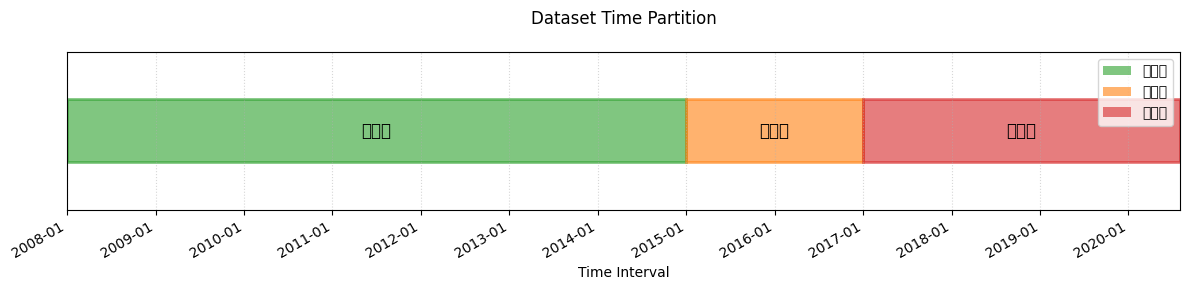

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.font_manager import FontProperties
from datetime import datetime
import pandas as pd

# 从配置中获取时间区间（示例数据，请替换为您的实际配置）
time_ranges = [
    ("Train", "2008-01-01", "2014-12-31", "#2ca02c"),
    ("Valid", "2015-01-01", "2016-12-31", "#ff7f0e"),
    ("Test", "2017-01-01", "2020-08-01", "#d62728")
]

# 转换为datetime对象
time_ranges = [
    (label, datetime.strptime(start, "%Y-%m-%d"), 
     datetime.strptime(end, "%Y-%m-%d"), color)
    for label, start, end, color in time_ranges
]

# 创建图表
fig, ax = plt.subplots(figsize=(12, 3))

# 绘制时间区间块
y = 1
for label, start, end, color in time_ranges:
    # 使用日期数值作为x轴坐标
    start_num = mdates.date2num(start)
    end_num = mdates.date2num(end)
    width = end_num - start_num
    
    rect = Rectangle(
        (start_num, y-0.4), width, 0.8,
        facecolor=color, alpha=0.6,
        edgecolor=color, linewidth=2
    )
    ax.add_patch(rect)
    
    # 添加标签
    ax.text(start_num + width/2, y, label,
            ha='center', va='center', fontsize=12)

# 设置坐标轴
ax.set_xlim(mdates.date2num(time_ranges[0][1]), 
            mdates.date2num(time_ranges[-1][2]))
ax.set_ylim(0, 2)
ax.yaxis.set_visible(False)

# 设置日期格式
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
fig.autofmt_xdate()

# 添加标题和网格
plt.title("Dataset Time Partition", pad=20)
plt.xlabel("Time Interval",)
plt.grid(axis='x', linestyle=':', alpha=0.5)

# 添加图例
legend_patches = [
    plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.6, label=label)
    for label, _, _, color in time_ranges
]
plt.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.savefig("./model/data_time_ranges.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# 检查索引类型
print("预测结果索引类型:", type(pred.index))
print("标签数据索引类型:", type(label_df.index))

# 检查索引层级
if isinstance(label_df.index, pd.MultiIndex):
    print("标签索引层级:", label_df.index.names)
else:
    print("标签索引是单级索引")

# 检查数据样例
print("预测数据前5行:\n", pred.head())
print("标签数据前5行:\n", label_df.head())

预测结果索引类型: <class 'pandas.core.indexes.multi.MultiIndex'>
标签数据索引类型: <class 'pandas.core.indexes.multi.MultiIndex'>
标签索引层级: ['datetime']
预测数据前5行:
                               0
datetime   instrument          
2017-01-03 SH600000   -0.088509
           SH600008    0.034699
           SH600009    0.114184
           SH600010   -0.067569
           SH600015    0.010013
标签数据前5行:
 instrument SH600000 SH600004 SH600008 SH600009 SH600010 SH600011 SH600015  \
datetime                                                                    
2016-12-21        0      NaN        1        2        3      NaN        4   
2016-12-22      300      NaN      301      302      303      NaN      304   
2016-12-23      600      NaN      601      602      603      NaN      604   
2016-12-26      900      NaN      901      902      903      NaN      904   
2016-12-27     1200      NaN     1201     1202     1203      NaN     1204   

instrument SH600016 SH600018 SH600019  ... SZ300251 SZ300296 SZ300315  \
datetime

In [7]:
all_metrics = {
    k: []
    for k in [
        "IC",
        "ICIR",
        "Rank IC",
        "Rank ICIR",
        "1day.excess_return_without_cost.annualized_return",
        "1day.excess_return_without_cost.information_ratio",
    ]
}

In [8]:
# backtest and analysis
import numpy as np


print(f"[Status]: Model Training/ Loading finished".upper())
with R.start(experiment_name="backtest_analysis"):
    recorder = R.get_recorder(recorder_id=rid, experiment_name="train_model")
    model = recorder.load_object("trained_model")

    # prediction
    recorder = R.get_recorder()
    ba_rid = recorder.id
    sr = SignalRecord(model, dataset, recorder)
    sr.generate()
    
    # Signal Analysis
    sar = SigAnaRecord(recorder)
    sar.generate()

    # backtest & analysis
    par = PortAnaRecord(recorder, port_analysis_config, "day")
    par.generate()
    
    metrics = recorder.list_metrics()
    print(f"Metrics: {metrics}")
    for k in all_metrics.keys():
        all_metrics[k].append(metrics[k])
    print(f"All metrics: {all_metrics}")
    print(f"Available metrics: {metrics.keys()}")
    
for k in all_metrics.keys():
        print(f"{k}: {np.mean(all_metrics[k])} +- {np.std(all_metrics[k])}")

recorder = R.get_recorder(recorder_id=ba_rid, experiment_name="backtest_analysis")

[94660:MainThread](2025-04-07 01:33:05,788) INFO - qlib.workflow - [exp.py:258] - Experiment 362767161650010529 starts running ...
[94660:MainThread](2025-04-07 01:33:05,822) INFO - qlib.workflow - [recorder.py:345] - Recorder 8e279bcb6138491da6ff8c768d6bd6cb starts running under Experiment 362767161650010529 ...


[STATUS]: MODEL TRAINING/ LOADING FINISHED


[94660:MainThread](2025-04-07 01:33:23,109) INFO - qlib.workflow - [record_temp.py:198] - Signal record 'pred.pkl' has been saved as the artifact of the Experiment 362767161650010529


'The following are prediction results of the MASTERModel model.'
                              0
datetime   instrument          
2017-01-03 SH600000   -0.088509
           SH600008    0.034699
           SH600009    0.114184
           SH600010   -0.067569
           SH600015    0.010013


[94660:MainThread](2025-04-07 01:33:23,854) INFO - qlib.backtest caller - [__init__.py:93] - Create new exchange


{'IC': 0.06221125738364682,
 'ICIR': 0.4089395569850118,
 'Rank IC': 0.07537232888943195,
 'Rank ICIR': 0.500439035041941}


[94660:MainThread](2025-04-07 01:33:28,886) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[94660:MainThread](2025-04-07 01:33:28,888) WARNING - qlib.online operator - [exchange.py:219] - $close field data contains nan.
[94660:MainThread](2025-04-07 01:33:28,895) WARNING - qlib.online operator - [exchange.py:226] - factor.day.bin file not exists or factor contains `nan`. Order using adjusted_price.
[94660:MainThread](2025-04-07 01:33:28,896) WARNING - qlib.online operator - [exchange.py:228] - trade unit 100 is not supported in adjusted_price mode.
[94660:MainThread](2025-04-07 01:33:44,761) WARNING - qlib.data - [data.py:665] - load calendar error: freq=day, future=True; return current calendar!
[94660:MainThread](2025-04-07 01:33:44,764) WARNING - qlib.data - [data.py:668] - You can get future calendar by referring to the following document: https://github.com/microsoft/qlib/blob/main/scripts/data_collector/contrib/README.md
[94660:MainThread](20

backtest loop:   0%|          | 0/871 [00:00<?, ?it/s]

/home/24039378g/QuantProject/QLIB/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/home/24039378g/QuantProject/QLIB/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
/home/24039378g/QuantProject/QLIB/qlib/utils/index_data.py:492: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.data)
[94660:MainThread](2025-04-07 01:33:57,492) INFO - qlib.workflow - [record_temp.py:515] - Portfolio analysis record 'port_analysis_1day.pkl' has been saved as the artifact of the Experiment 362767161650010529
[94660:MainThread](2025-04-07 01:33:57,499) INFO - qlib.workflow - [record_temp.py:540] - Indicator analysis record 'indicator_analysis_1day.pkl' has been saved as the artifact of the Experiment 362767161650010529


'The following are analysis results of benchmark return(1day).'
                       risk
mean               0.000477
std                0.012295
annualized_return  0.113561
information_ratio  0.598699
max_drawdown      -0.370479
'The following are analysis results of the excess return without cost(1day).'
                       risk
mean               0.000769
std                0.006422
annualized_return  0.182988
information_ratio  1.846895
max_drawdown      -0.077623
'The following are analysis results of the excess return with cost(1day).'
                       risk
mean              -0.000647
std                0.006410
annualized_return -0.153964
information_ratio -1.556917
max_drawdown      -0.556260
'The following are analysis results of indicators(1day).'
     value
ffr    1.0
pa     0.0
pos    0.0


[94660:MainThread](2025-04-07 01:33:58,777) INFO - qlib.timer - [log.py:127] - Time cost: 0.001s | waiting `async_log` Done


Metrics: {'1day.ffr': 1.0, 'Rank ICIR': 0.500439035041941, '1day.excess_return_with_cost.information_ratio': -1.5569168277968284, '1day.excess_return_with_cost.annualized_return': -0.1539640160616905, '1day.excess_return_without_cost.information_ratio': 1.8468949496149516, '1day.pos': 0.0, 'IC': 0.06221125738364682, 'ICIR': 0.4089395569850118, '1day.pa': 0.0, '1day.excess_return_without_cost.std': 0.006422333820235034, 'Rank IC': 0.07537232888943195, '1day.excess_return_with_cost.mean': -0.0006469076305113046, '1day.excess_return_without_cost.mean': 0.0007688588023103395, '1day.excess_return_with_cost.max_drawdown': -0.5562598572484698, '1day.excess_return_without_cost.max_drawdown': -0.07762253352198856, '1day.excess_return_with_cost.std': 0.006410107895452495, '1day.excess_return_without_cost.annualized_return': 0.1829883949498608}
All metrics: {'IC': [0.06221125738364682], 'ICIR': [0.4089395569850118], 'Rank IC': [0.07537232888943195], 'Rank ICIR': [0.500439035041941], '1day.excess_

In [9]:
pred_df = recorder.load_object("pred.pkl")

report_normal_df = recorder.load_object("portfolio_analysis/report_normal_1day.pkl")

positions = recorder.load_object("portfolio_analysis/positions_normal_1day.pkl")

analysis_df = recorder.load_object("portfolio_analysis/port_analysis_1day.pkl")

In [10]:
from qlib.contrib.report import analysis_model, analysis_position
import pandas as pd

save_dir = "figure_results"
os.makedirs(save_dir, exist_ok=True)

figs = analysis_position.report_graph(report_normal_df, show_notebook=False)
if not figs:
    raise ValueError("No figures were generated by `report_graph`. Please check the input data.")

for i, _fig in enumerate(figs):
    fig_path = f"{save_dir}/报告图表{i}.png"
    try:
        _fig.write_image(fig_path)
        print(f"Saved figure {i} to {fig_path}")
    except Exception as e:
        print(f"Error saving figure {i}: {e}")

figs = analysis_position.risk_analysis_graph(analysis_df, report_normal_df, show_notebook=False)
if not figs:
    raise ValueError("No figures were generated by `risk_analysis_graph`. Please check the input data.")

for i, _fig in enumerate(figs):
    fig_path = f"{save_dir}/风险分析图表{i}.png"
    try:
        _fig.write_image(fig_path)
        print(f"Saved figure {i} to {fig_path}")
    except Exception as e:
        print(f"Error saving figure {i}: {e}")

# Step 1: Retrieve TSDataSampler and extract the underlying DataFrame
label_sampler = dataset.prepare(segments="test", col_set="label", only_label=True)
label_df = label_sampler.idx_df  # Extract the DataFrame

# Step 2: Reshape label_df to long format
label_df = label_df.reset_index()  # Include datetime as a column
label_df_long = pd.melt(
    label_df,
    id_vars=["datetime"],  # Keep datetime as is
    var_name="instrument",  # Former column names become instrument names
    value_name="label"  # Values in the DataFrame become the label column
)
label_df_long = label_df_long.dropna(subset=["label"])  # Drop NaN labels

# Debugging: Check the reshaped DataFrame
print("Reshaped label DataFrame:")
print(label_df_long.head())

# Step 3: Combine with predictions
# Ensure pred_df is in the long format with columns: datetime, instrument, prediction
pred_label = pd.merge(label_df_long, pred_df, on=["datetime", "instrument"], how="inner")

# Step 4: Rename the prediction column to 'score'
pred_label = pred_label.rename(columns={0: "score"})

# Drop rows with NaNs in the `label` or `score` columns
pred_label = pred_label.dropna(subset=["label", "score"])

# Verify there are no NaNs remaining
print(pred_label.isna().sum())

# Convert `label` and `score` columns to numeric, coercing errors to NaN
pred_label["label"] = pd.to_numeric(pred_label["label"], errors="coerce")
pred_label["score"] = pd.to_numeric(pred_label["score"], errors="coerce")

# Step 5: Set datetime and instrument as a multi-level index
pred_label = pred_label.set_index(["datetime", "instrument"])  # Set the multi-level index

# Verify the final structure

figs = analysis_position.score_ic_graph(pred_label, show_notebook=False)
for i, _fig in enumerate(figs):
    fig_path = f"{save_dir}/IC图表{i}.png"
    try:
        _fig.write_image(fig_path)
        print(f"Saved figure {i} to {fig_path}")
    except Exception as e:
        print(f"Error saving figure {i}: {e}")

figs = analysis_model.model_performance_graph(pred_label, show_notebook=False)
for i, _fig in enumerate(figs):
    fig_path = f"{save_dir}/模型性能图表{i}.png"
    try:
        _fig.write_image(fig_path)
        print(f"Saved figure {i} to {fig_path}")
    except Exception as e:
        print(f"Error saving figures {i}: {e}")


print(f"[Status]: Mission Completed".upper())

Saved figure 0 to figure_results/报告图表0.png


/home/24039378g/QuantProject/QLIB/qlib/contrib/report/analysis_position/risk_analysis.py:102: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/24039378g/QuantProject/QLIB/qlib/contrib/report/analysis_position/risk_analysis.py:102: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/24039378g/QuantProject/QLIB/qlib/contrib/report/analysis_position/risk_analysis.py:102: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/home/24039378g/QuantProject/QLIB/qlib/contrib/report/analysis_position/risk_analysis.py:102: FutureWarning:

When groupi

Saved figure 0 to figure_results/风险分析图表0.png
Saved figure 1 to figure_results/风险分析图表1.png
Saved figure 2 to figure_results/风险分析图表2.png
Saved figure 3 to figure_results/风险分析图表3.png
Saved figure 4 to figure_results/风险分析图表4.png
Reshaped label DataFrame:
    datetime instrument label
0 2016-12-21   SH600000     0
1 2016-12-22   SH600000   300
2 2016-12-23   SH600000   600
3 2016-12-26   SH600000   900
4 2016-12-27   SH600000  1200
datetime      0
instrument    0
label         0
score         0
dtype: int64
Saved figure 0 to figure_results/IC图表0.png


/home/24039378g/QuantProject/QLIB/qlib/contrib/report/analysis_model/analysis_model_performance.py:155: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



Saved figure 0 to figure_results/模型性能图表0.png
Saved figure 1 to figure_results/模型性能图表1.png
Saved figure 2 to figure_results/模型性能图表2.png
Saved figure 3 to figure_results/模型性能图表3.png
Saved figure 4 to figure_results/模型性能图表4.png
Saved figure 5 to figure_results/模型性能图表5.png
[STATUS]: MISSION COMPLETED
